<a href="https://colab.research.google.com/github/abidamer95/compvision/blob/notebooks/Evaluation_and_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import classification_report

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
test_transforms = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#create data loader
test_data = datasets.Flowers102(root='./data', split='test', download=True, transform=test_transforms)

test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=None)

#modify final layer
num_ftrs = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 102)
)

model.load_state_dict(torch.load("/content/drive/MyDrive/models/best_resnet50_flowers.pth", map_location=device))
model = model.to(device)

In [16]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [17]:
flower_names = ['pink primrose',
                'hard-leaved pocket orchid',
                'canterbury bells',
                'sweet pea',
                'english marigold',
                'tiger lily',
                'moon orchid',
                'bird of paradise',
                'monkshood',
                'globe thistle',
                'snapdragon',
                "colt's foot",
                'king protea',
                'spear thistle',
                'yellow iris',
                'globe-flower',
                'purple coneflower',
                'peruvian lily',
                'balloon flower',
                'giant white arum lily',
                'fire lily',
                'pincushion flower',
                'fritillary',
                'red ginger',
                'grape hyacinth',
                'corn poppy',
                'prince of wales feathers',
                'stemless gentian',
                'artichoke',
                'sweet william',
                'carnation',
                'garden phlox',
                'love in the mist',
                'mexican aster',
                'alpine sea holly',
                'ruby-lipped cattleya',
                'cape flower',
                'great masterwort',
                'siam tulip',
                'lenten rose',
                'barbeton daisy',
                'daffodil',
                'sword lily',
                'poinsettia',
                'bolero deep blue',
                'wallflower',
                'marigold',
                'buttercup',
                'oxeye daisy',
                'common dandelion',
                'petunia',
                'wild pansy',
                'primula',
                'sunflower',
                'pelargonium',
                'bishop of llandaff',
                'gaura',
                'geranium',
                'orange dahlia',
                'pink-yellow dahlia?',
                'cautleya spicata',
                'japanese anemone',
                'black-eyed susan',
                'silverbush',
                'californian poppy',
                'osteospermum',
                'spring crocus',
                'bearded iris',
                'windflower',
                'tree poppy',
                'gazania',
                'azalea',
                'water lily',
                'rose',
                'thorn apple',
                'morning glory',
                'passion flower',
                'lotus',
                'toad lily',
                'anthurium',
                'frangipani',
                'clematis',
                'hibiscus',
                'columbine',
                'desert-rose',
                'tree mallow',
                'magnolia',
                'cyclamen ',
                'watercress',
                'canna lily',
                'hippeastrum ',
                'bee balm',
                'ball moss',
                'foxglove',
                'bougainvillea',
                'camellia',
                'mallow',
                'mexican petunia',
                'bromelia',
                'blanket flower',
                'trumpet creeper',
                'blackberry lily']

print(classification_report(all_labels, all_preds, target_names=flower_names))

                           precision    recall  f1-score   support

            pink primrose       0.41      0.90      0.56        20
hard-leaved pocket orchid       0.92      0.90      0.91        40
         canterbury bells       0.36      0.50      0.42        20
                sweet pea       0.44      0.31      0.36        36
         english marigold       0.87      0.91      0.89        45
               tiger lily       0.92      0.96      0.94        25
              moon orchid       0.54      0.95      0.69        20
         bird of paradise       0.97      1.00      0.98        65
                monkshood       0.40      0.96      0.56        26
            globe thistle       0.89      1.00      0.94        25
               snapdragon       0.67      0.72      0.69        67
              colt's foot       0.97      0.91      0.94        67
              king protea       0.64      1.00      0.78        29
            spear thistle       0.93      0.96      0.95     

Create a confusion matrix to visualize model prediction

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

(102, 102)


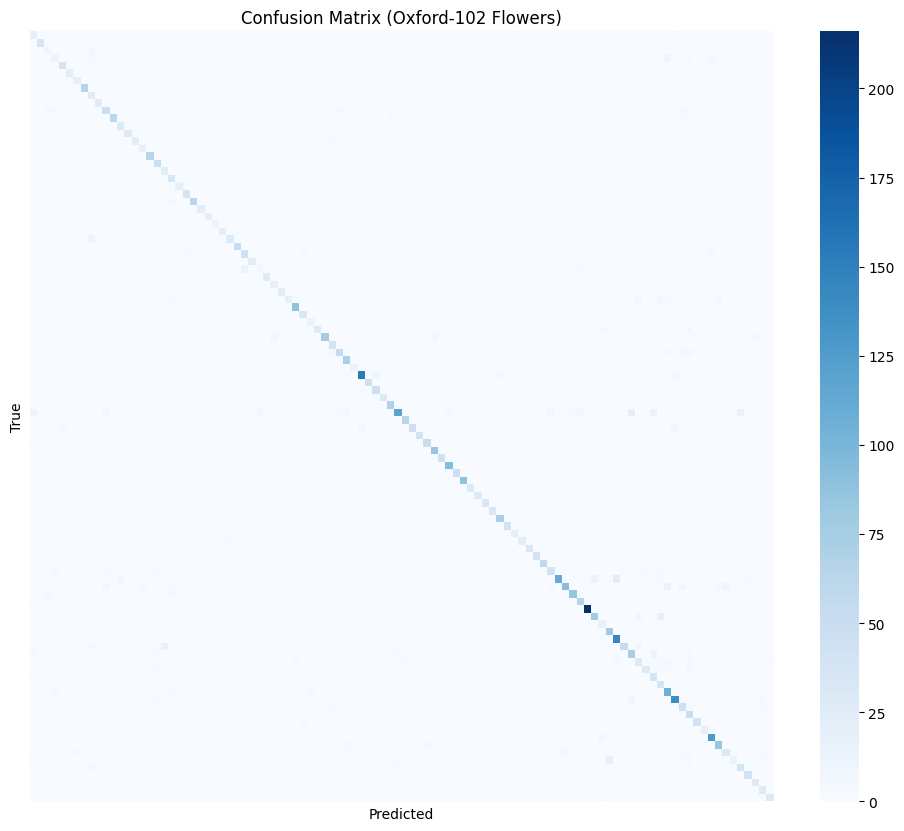

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Oxford-102 Flowers)")
plt.show()

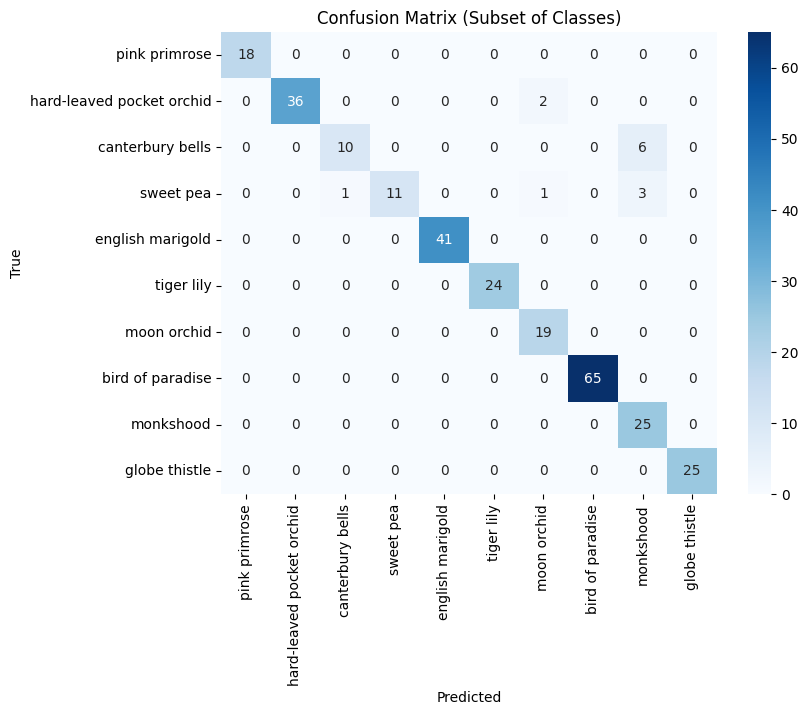

In [22]:
import numpy as np

subset = list(range(10))  # first 10 classes
cm_subset = cm[np.ix_(subset, subset)]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_subset,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[flower_names[i] for i in subset],
    yticklabels=[flower_names[i] for i in subset]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Subset of Classes)")
plt.show()